In [290]:
import cv2 as cv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
def disp_img(img):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

In [3]:
mpl.rcParams['figure.dpi']= 150

In [190]:
img = cv.imread('hard_test.jpg')

In [191]:
img.shape

(648, 1152, 3)

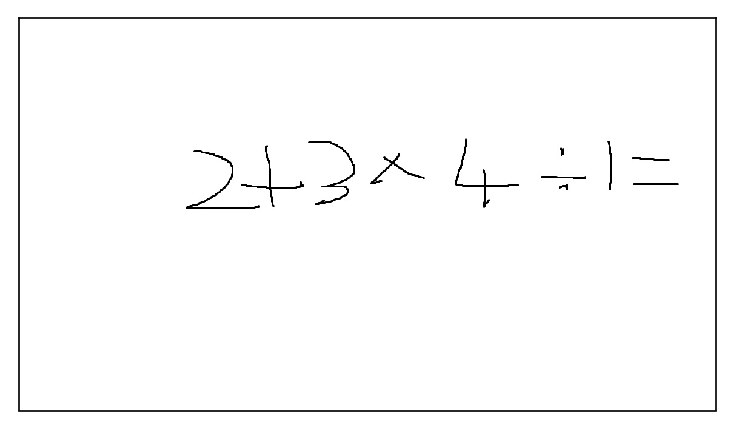

In [192]:
disp_img(img)

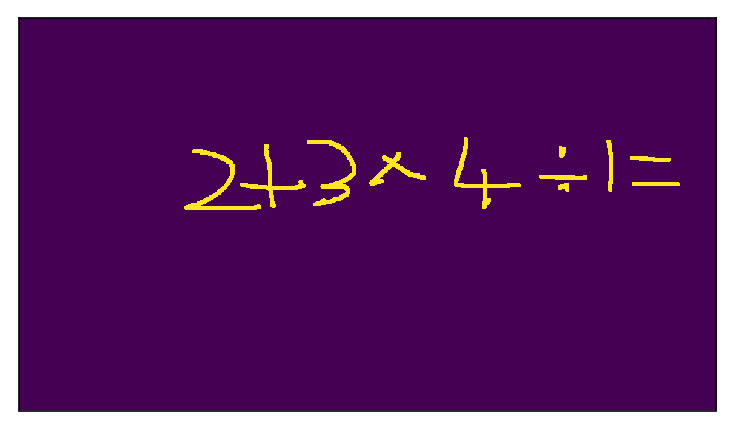

In [193]:
gray = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(gray, (5, 5), 10)
thresh = cv.adaptiveThreshold(blurred, 255, 0, 1, 115, 1)

disp_img(thresh)

In [200]:
kernel = np.ones((3,3),np.uint8)
dilation = cv.dilate(thresh,kernel,iterations = 0)

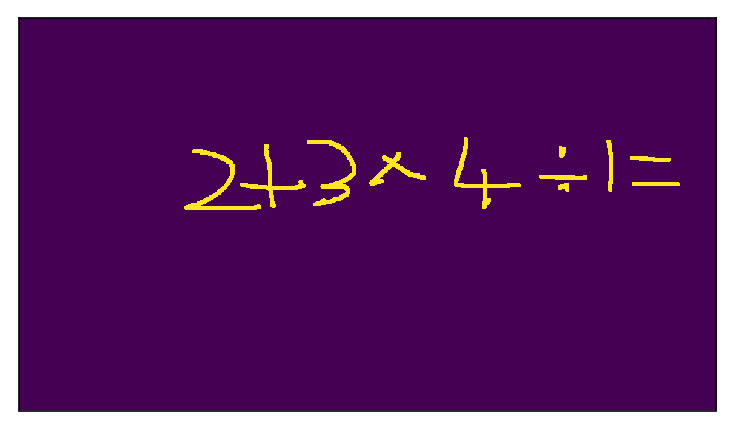

In [222]:
disp_img(dilation)

In [220]:
original_img = img.copy()
contours, hierarchy = cv.findContours(dilation,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[0])
try: hierarchy = hierarchy[0]
except: hierarchy = []

height, width = dilation.shape
min_x, min_y = width, height
max_x = max_y = 0

# computes the bounding box for the contour, and draws it on the frame,
for contour, hier in zip(contours, hierarchy):
    (x,y,w,h) = cv.boundingRect(contour)
    min_x, max_x = min(x, min_x), max(x+w, max_x)
    min_y, max_y = min(y, min_y), max(y+h, max_y)
    cv.rectangle(original_img, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)

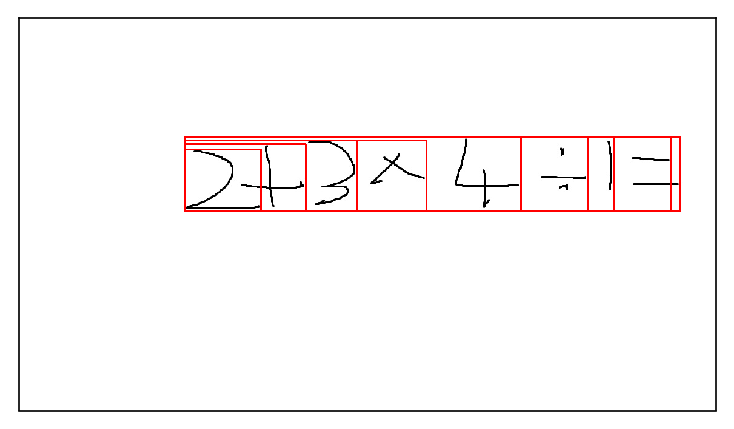

In [221]:
disp_img(original_img)

In [308]:
contours, hierarchy = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[0])
rects = [cv.boundingRect(ctr) for ctr in contours]

In [309]:
contours

[array([[[287, 218]],
 
        [[286, 219]],
 
        [[286, 224]],
 
        [[297, 224]],
 
        [[299, 226]],
 
        [[305, 226]],
 
        [[306, 227]],
 
        [[311, 227]],
 
        [[312, 228]],
 
        [[316, 228]],
 
        [[317, 229]],
 
        [[318, 229]],
 
        [[320, 231]],
 
        [[322, 231]],
 
        [[323, 232]],
 
        [[327, 232]],
 
        [[328, 233]],
 
        [[330, 233]],
 
        [[333, 236]],
 
        [[335, 236]],
 
        [[336, 237]],
 
        [[337, 237]],
 
        [[338, 238]],
 
        [[340, 238]],
 
        [[341, 239]],
 
        [[341, 240]],
 
        [[342, 241]],
 
        [[344, 241]],
 
        [[346, 243]],
 
        [[346, 245]],
 
        [[347, 246]],
 
        [[347, 247]],
 
        [[349, 249]],
 
        [[349, 257]],
 
        [[348, 258]],
 
        [[348, 261]],
 
        [[347, 262]],
 
        [[347, 263]],
 
        [[345, 265]],
 
        [[345, 266]],
 
        [[344, 267]],
 
        [[344, 2

In [318]:
rects

[(273, 218, 126, 101),
 (365, 209, 108, 106),
 (475, 203, 82, 109),
 (578, 222, 94, 56),
 (718, 198, 110, 119),
 (859, 260, 79, 9),
 (889, 273, 19, 15),
 (891, 213, 11, 19),
 (969, 202, 12, 86),
 (1009, 229, 67, 10),
 (1011, 272, 80, 7)]

In [312]:
new_rects = []
pad = 2
for rect in rects:
    if rect[2]/rect[3] > 5:
        temp = []
        temp.append(rect[0]-pad)
        temp.append(rect[1]-int(rect[2]))
        temp.append(rect[2]+pad)
        temp.append(rect[3]+int(2 * rect[2]))
        new_rects.append(tuple(temp))
    else:
        new_rects.append(rect)

In [317]:
new_rects

[(273, 218, 126, 101),
 (365, 209, 108, 106),
 (475, 203, 82, 109),
 (578, 222, 94, 56),
 (718, 198, 110, 119),
 (857, 181, 81, 167),
 (889, 273, 19, 15),
 (891, 213, 11, 19),
 (969, 202, 12, 86),
 (1007, 162, 69, 144),
 (1009, 192, 82, 167)]

In [298]:
def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return (x, y, w, h)

def intersection(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w<0 or h<0: return () # or (0,0,0,0) ?
    return (x, y, w, h)

In [299]:
def rect_area(rect):
    try:
        return rect[2] * rect[3]
    except IndexError:
        return 0

In [236]:
rects2 = combine_boxes(rects)

In [300]:
rect_areas = [rect_area(i) for i in new_rects]

In [316]:
final_rects = []

In [320]:
from itertools import combinations
windows = list(zip(new_rects, new_rects[1:], new_rects[2:]))
final_rects = deepcopy(new_rects)
for window in windows:
    for combination in combinations(window, 2):
        combination = list(combination)
        common = intersection(combination[0], combination[1])
        area_common = rect_area(common)
        area1 = rect_area(combination[0])
        area2 = rect_area(combination[1])
        combination = sorted(combination, key=lambda x: rect_area(x), reverse=True)
        try:
            if area_common == area1 or area_common == area2:
                final_rects.remove(combination[-1])
            if area_common > area1/2 and area_common > area2/2:
                final_rects.remove(combination[-1])
        except ValueError:
            pass

In [283]:
sorted(new_rects, key=lambda x: rect_area(x), reverse=True)

[(1009, 192, 82, 167),
 (857, 181, 81, 167),
 (718, 198, 110, 119),
 (273, 218, 126, 101),
 (365, 209, 108, 106),
 (1007, 162, 69, 144),
 (475, 203, 82, 109),
 (578, 222, 94, 56),
 (969, 202, 12, 86),
 (889, 273, 19, 15),
 (891, 213, 11, 19)]

In [331]:
output_img = img.copy()
extracted_rects = []
pad = 1
for (x, y, w, h) in final_rects:
    extracted_rects.append(dilation.copy()[y-pad: y + h+pad, x-pad: x + w+pad])
    rect = cv.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 255), 3)

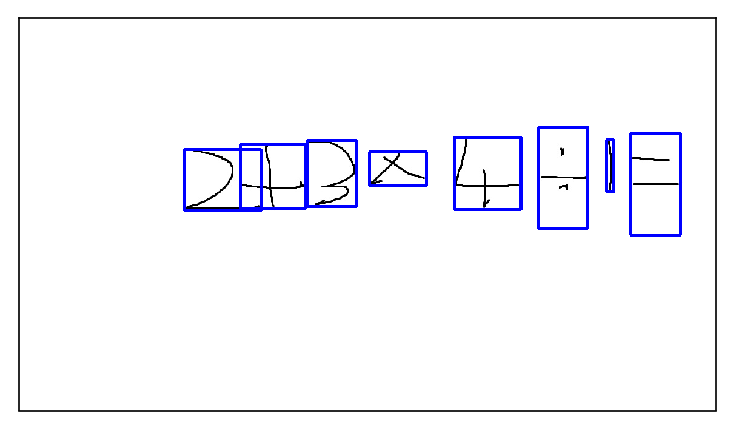

In [332]:
disp_img(output_img)

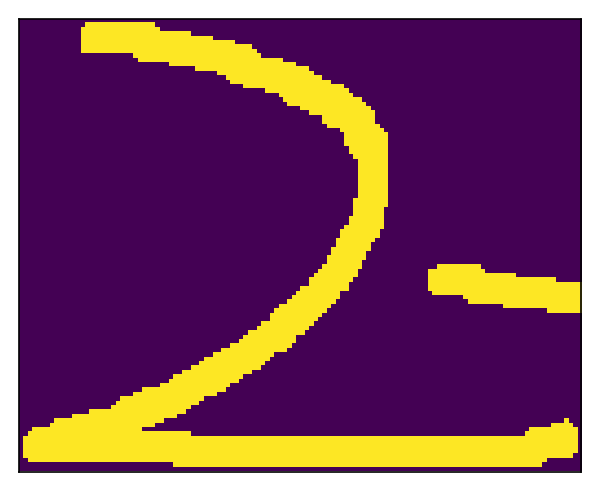

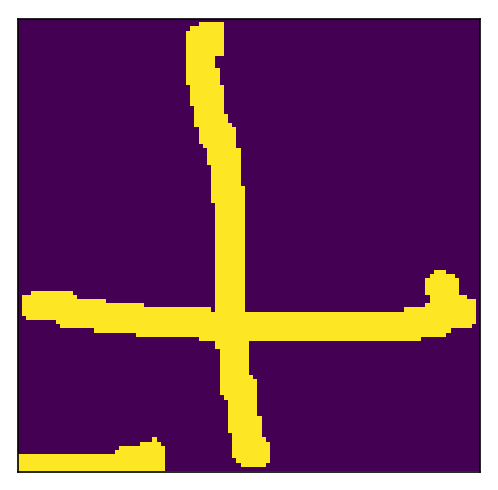

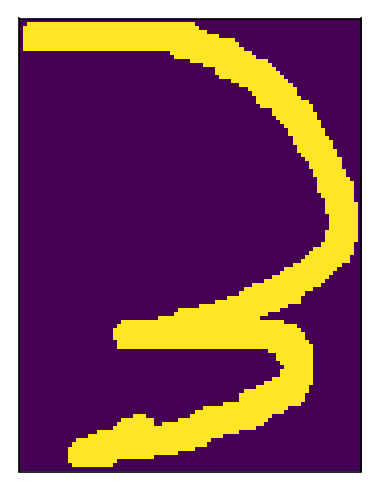

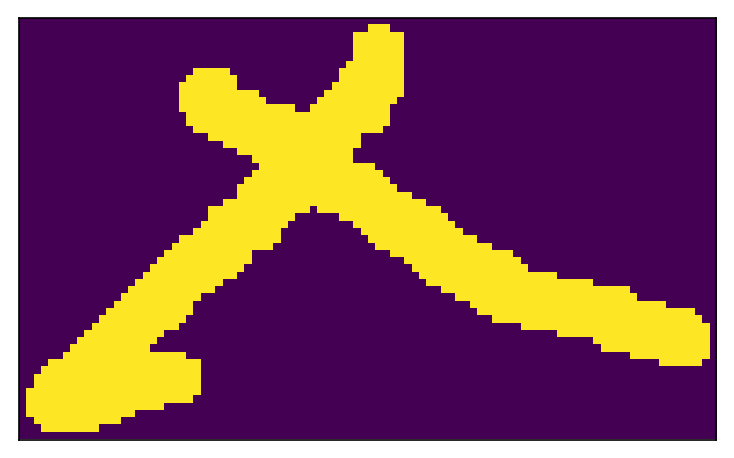

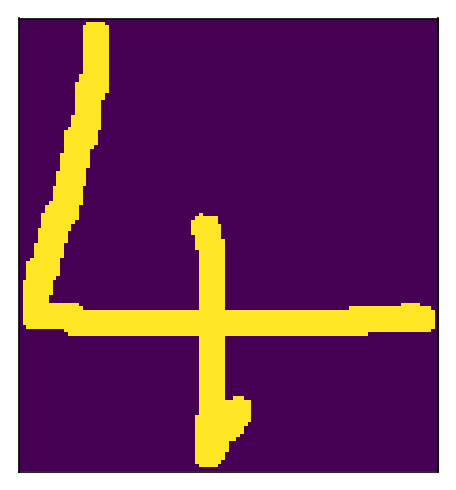

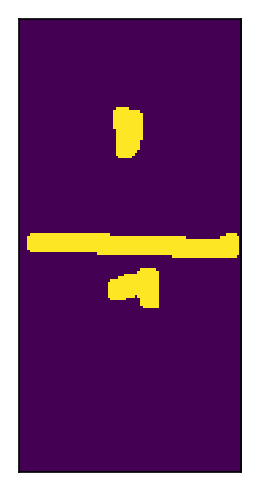

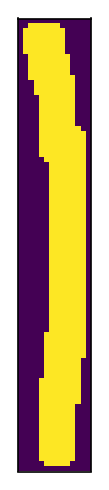

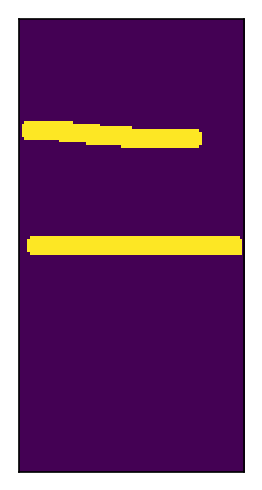

In [333]:
for i in extracted_rects:
    disp_img(i)

In [334]:
square_padded_digits = []
b_pad = 0
for i in extracted_rects:
    old_size = i.shape
    desired_size = max(i.shape)

    delta_w = desired_size - old_size[1]
    delta_h = desired_size - old_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    square_padded_digits.append(cv.copyMakeBorder(i, top+b_pad, bottom+b_pad, left+b_pad, right+b_pad, cv.BORDER_REPLICATE))

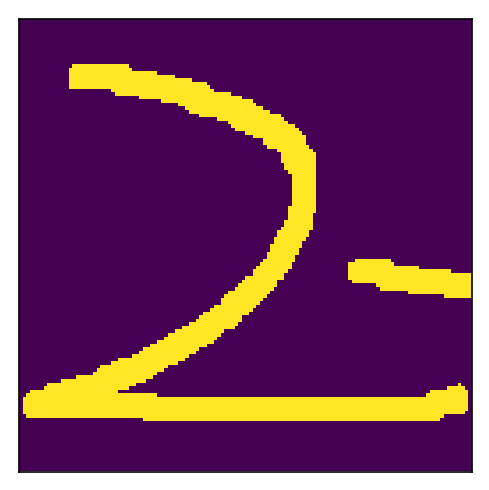

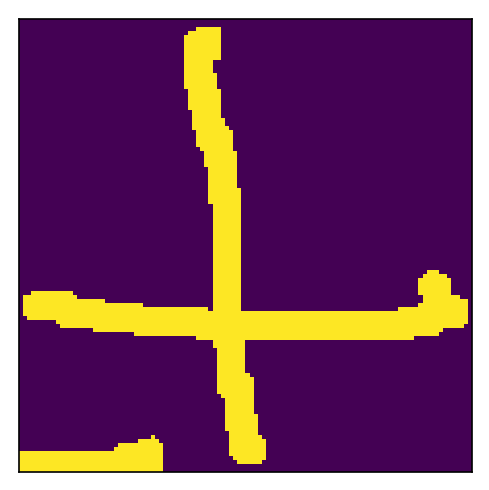

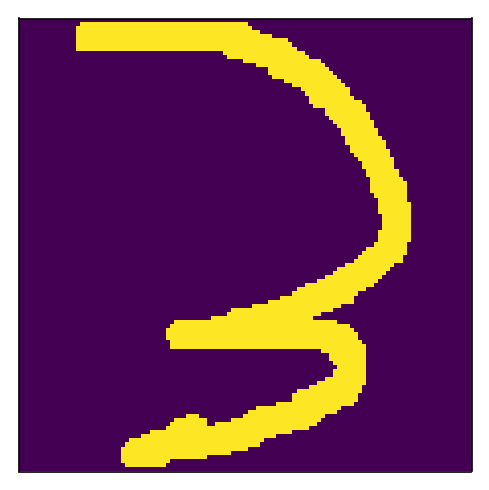

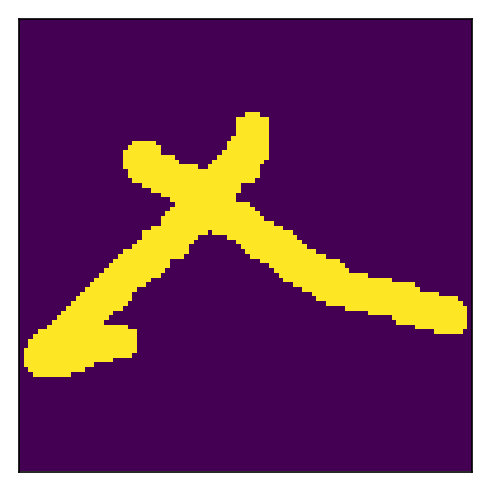

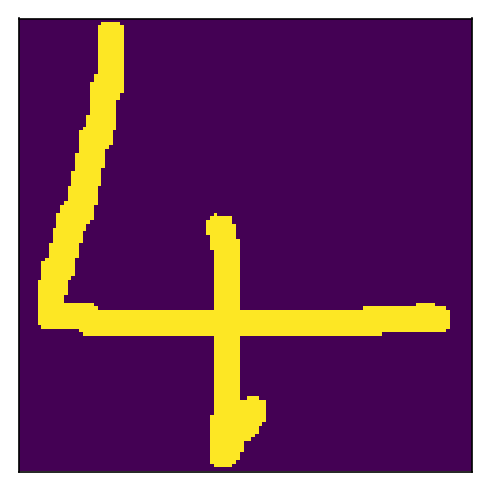

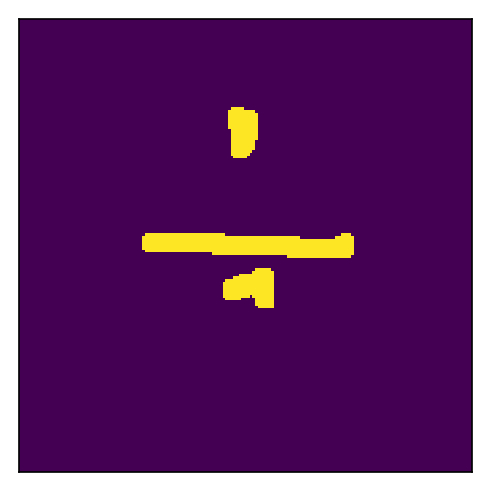

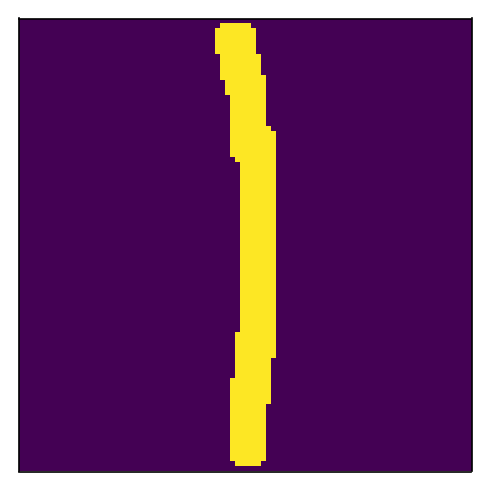

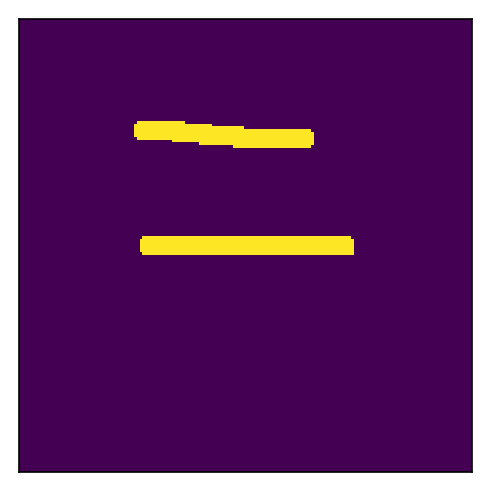

In [335]:
for i in square_padded_digits:
    disp_img(i)

In [29]:
for ctr in contours:
    print(cv.contourArea(cnt))
    print(cv.arcLength(cnt,True))
#     top_right = ctr[0] + [2]
#     bottom_right = ctr[1] + ctr[3]
#     x1 = ctr[0]
#     x2 = ctr[0] + ctr[2]

613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847
613.5
159.55634891986847


In [46]:
ouput_img2 = img.copy()
for cnt in contours:
    (x,y),radius = cv.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    radius = int(radius)
    cv.circle(ouput_img2,center,radius,(0,255,0),2)

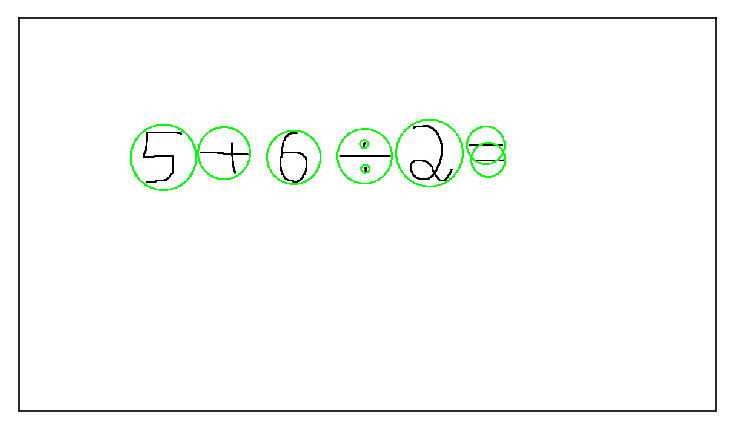

In [47]:
disp_img(ouput_img2)

In [ ]:
def get_image():
    for (x, y, w, h) in rects:
    extracted_rects.append(dilation.copy()[y-pad: y + h+pad, x-pad: x + w+pad])
    rect = cv.rectangle(ouput_img, (x, y), (x + w, y + h), (0, 0, 255), 3)
    square_padded_digits = []
    b_pad = 3
    for i in extracted_rects:
        old_size = i.shape
        desired_size = max(i.shape)

        delta_w = desired_size - old_size[1]
        delta_h = desired_size - old_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        square_padded_digits.append(cv.copyMakeBorder(i, top+b_pad, bottom+b_pad, left+b_pad, right+b_pad, cv.BORDER_REPLICATE))

In [ ]:
final_rect = []
for rect in rects:
    print(rect)
    if model.precict()
    final_rect.appen(rect)

In [340]:
img_copy4 = dilation.copy()
contours, hierarchy = cv.findContours(img_copy4,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

try: hierarchy = hierarchy[0]
except: hierarchy = []

height, width = img_copy4.shape
min_x, min_y = width, height
max_x = max_y = 0

# computes the bounding box for the contour, and draws it on the frame,
for contour, hier in zip(contours, hierarchy):
    (x,y,w,h) = cv.boundingRect(contour)
    min_x, max_x = min(x, min_x), max(x+w, max_x)
    min_y, max_y = min(y, min_y), max(y+h, max_y)
    if w > 80 and h > 80:
        cv.rectangle(output_img, (x,y), (x+w,y+h), (255, 0, 0), 2)

if max_x - min_x > 0 and max_y - min_y > 0:
    cv.rectangle(output_img, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)

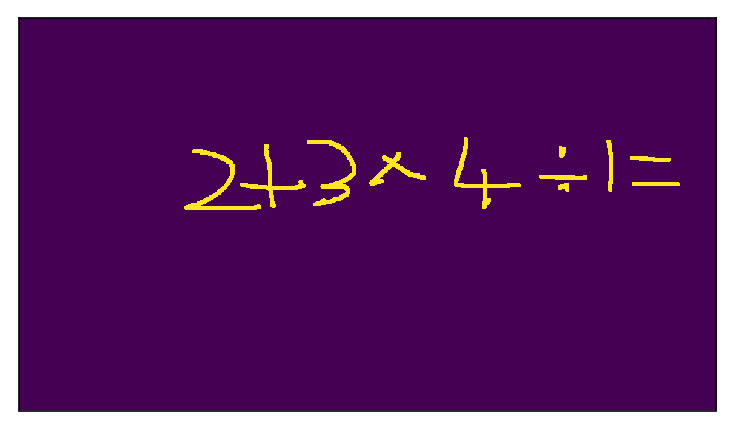

In [341]:
disp_img(img_copy4)

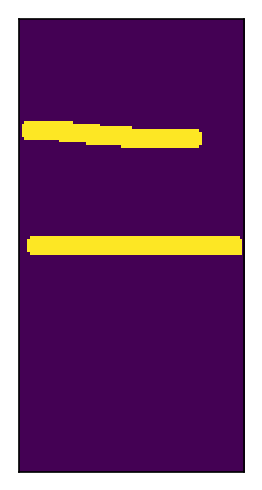

In [337]:
disp_img(extracted_rects[7])